In [8]:
import numpy as np
from numpy import radians, pi
from lib.cartpolesystem import CartPoleSystem
from lib.cartpoleenv import CartPoleEnv
from lib.colors import Colors
from lib.controllers import LQR
import time
from matplotlib import pyplot as plt
from scipy.io import savemat
from time import perf_counter

In [9]:
dt = 0.01
g = 9.81

system_noise = 0.000000001 * np.diag(np.ones(6))

system = CartPoleSystem(
    (0.0, 0.5, 0.005, -0.8, 0.8, Colors.red),
    (0.2, 8.7e-5, 8.7e-5, 0.02, 0.05, -24.0, 24.0, Colors.black),
    [
        (0, 0.5, 0.2, 0.005, Colors.green),
        (0, 0.2, 0.15, 0.005, Colors.blue),
    ],
    g,
    dt,
    "rk4",
    "linear",
    system_noise
)

env = CartPoleEnv(system, dt, g)
env.observation_space.shape

(6, 1)

In [10]:
linearization_x0 = np.vstack([0, 0, 0, 0, 0, 0])
linearization_u0 = np.vstack([0])

# A, B = system.linearize_old()
A, B = system.linearize(linearization_x0, linearization_u0)

savemat("AB.mat", {"A": A, "B": B})

C = np.diag([1, 1, 1, 1, 1, 1])
D = np.zeros((6, 1))

ct_dt = dt

sys = LQR(A, B, C, D, dt=ct_dt)

Q = np.diag([1, 1, 1, 1, 1, 1])
R = np.diag([0.1])

sys.calculate_K_lqr(Q, R)
sys.calculate_K_r()

In [11]:
x0 = np.vstack([-0.4, 0, radians(15), 0, radians(-5), 0])

obs, _ = env.reset()

r = np.vstack(
    [0.1, 0, 0, 0, 0, 0]
)

end_time = 10
N = int(end_time/dt)

states = {
    "u": [],
    "i": [],
}

last_update = perf_counter()

for i in range(N):

    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()
    
    u = sys.feedforward_d(obs, r)
    max_Ia = 10
    max_Va_from_Ia = system.Ra * max_Ia + system.K*obs[1]/system.r
    min_Va_from_Ia = -max_Va_from_Ia

    if u[0] > min(system.max_Va, max_Va_from_Ia):
        u[0] = min(system.max_Va, max_Va_from_Ia)
    elif u[0] < max(system.min_Va, min_Va_from_Ia):
        u[0] = max(system.min_Va, min_Va_from_Ia)

    states["u"].append(u[0][0])
    states["i"].append((u[0][0] - system.K*obs[1]/system.r)/system.Ra)

    obs, reward, done, msg, _ = env.step(u)
    env.render()
env.close()

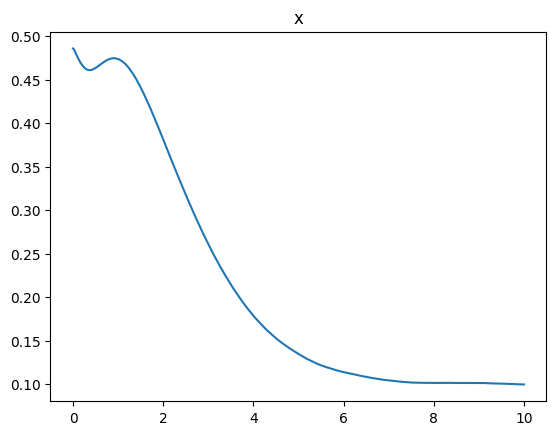

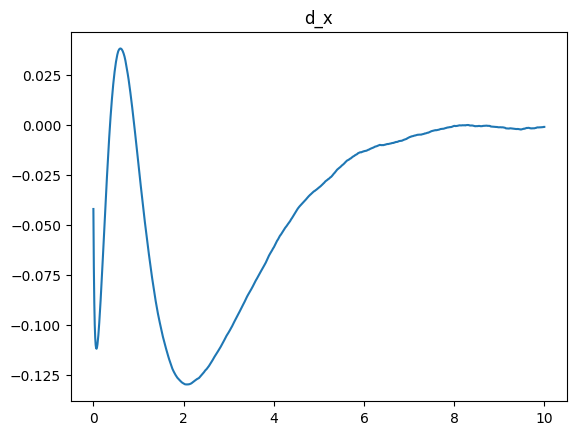

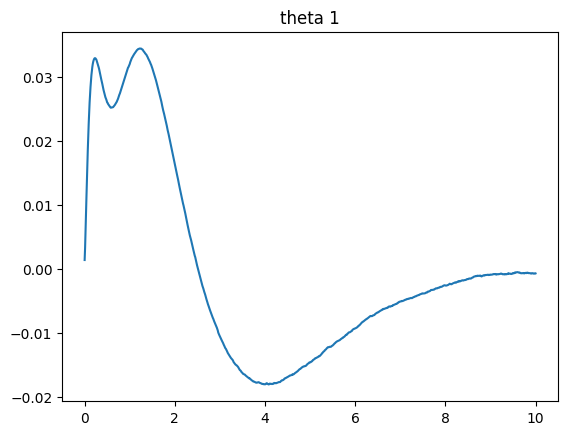

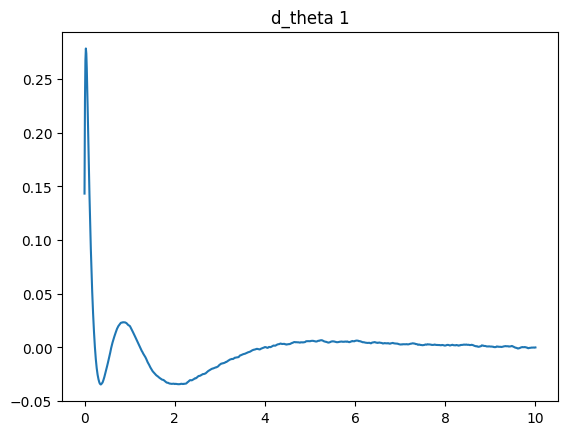

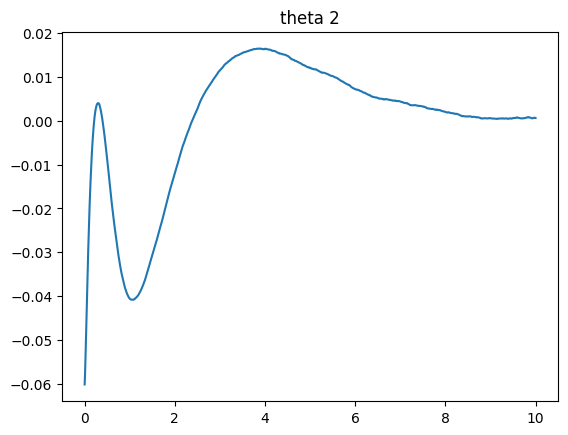

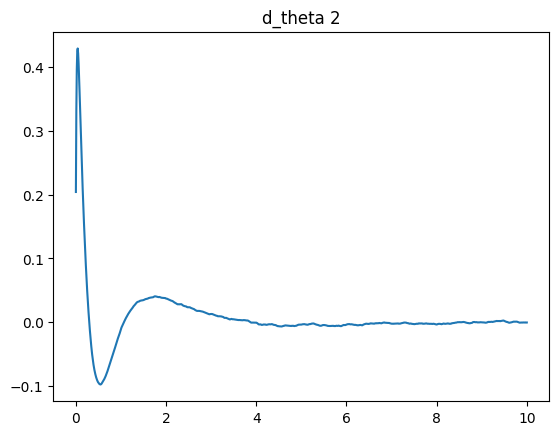

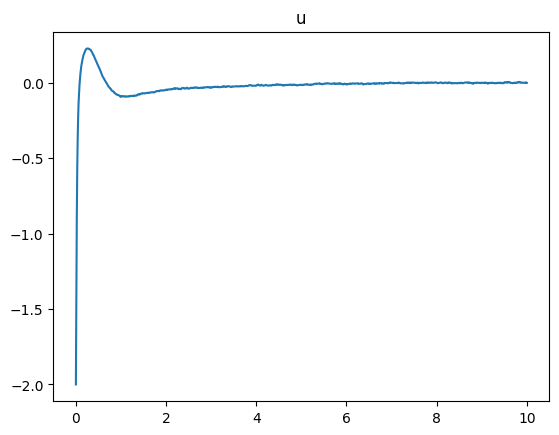

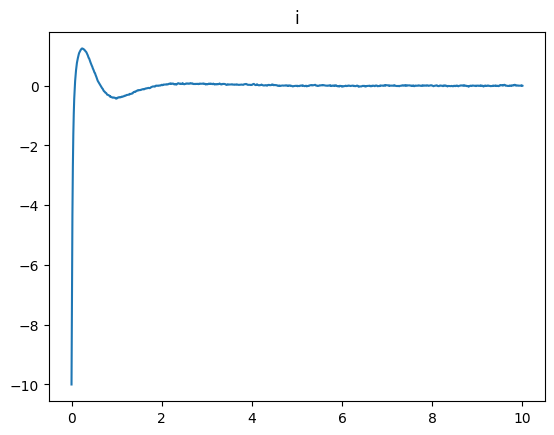

In [12]:
t = np.linspace(0, end_time, N)
x = env.system.state[0][1:]

plt.plot(t, x)
plt.title("x")
plt.show()

d_x = env.system.state[1][1:]

plt.plot(t, d_x)
plt.title("d_x")
plt.show()

for k in range(system.num_poles):
    theta = env.system.state[2+k*2][1:]

    plt.plot(t, theta)
    plt.title(f"theta {k+1}")
    plt.show()

    d_theta = env.system.state[2+k*2+1][1:]

    plt.plot(t, d_theta)
    plt.title(f"d_theta {k+1}")
    plt.show()

plt.plot(t, states["u"])
plt.title("u")
plt.show()

plt.plot(t, states["i"])
plt.title("i")
plt.show()